In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt

This workbook implements the models described in the 1990 paper [Neural Networks and Dynamical Systems](https://doi.org/10.1016/0888-613X(92)90014-Q) and [Identification and control of dynamical systems using neural networks](https://doi.org/10.1109/72.80202) using the ML framework Jax.

# Example 1
The nonlinear plant is defined by the difference equation
$$y_p(k+2)=f\big[y_p(k+1),y_p(k)\big]+u(k)$$
where
$$f\big[y_p(k+1),y_p(k)\big]=\frac{y_p(k+1)y_p(k)\big[y_p(k+1)+2.5\big]}{1+y_p^2(k+1)+y_p^2(k)}$$
and a linear reference model is described by the second-order equation
$$y_m(k+2)=0.6y_m(k+1)+0.2y_m(k)+r(k)$$
where $r(k)$ is a bounded reference input.

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


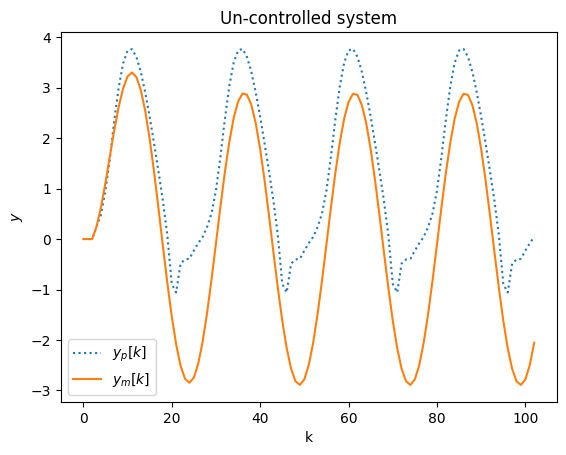

In [2]:
def simulate_plant_no_control(Y,U,R):

  Y = [Y[0],Y[1]]

  for r in R:
    # while it is not clearly stated in the paper, setting u(k) = r(k) 
    # seems to produce a plot that matches theirs. It seems that
    # "without control" is really means control IS reference input
    y_next = Y[-1]*Y[-2]*(Y[-1]+2.5) / (1.0+Y[-1]**2+Y[-2]**2) + r
    Y.append(y_next)
  return jnp.stack(Y)

def simulate_model(Y,R):
  Y = [Y[0],Y[1]]
  for r in R:
    y_next = 0.6*Y[-1] + 0.2*Y[-2] + r
    Y.append(y_next)
  return jnp.stack(Y)

Y = jnp.array([0.0,0.0])
U = jnp.zeros(1)
k = jnp.arange(101)
R = jnp.sin(2*jnp.pi*k/25)
Yp = simulate_plant_no_control(Y,U,R)
Ym = simulate_model(Y,R)

plt.plot(Yp,label="$y_p[k]$", linestyle="dotted")
plt.plot(Ym,label="$y_m[k]$")
plt.legend()
plt.xlabel("k")
plt.ylabel("$y$")
plt.title("Un-controlled system");

## Controlled system

In [ ]:
key = random.PRNGKey(0)

def init_mlp_params(layer_widths, key):
  params = []
  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(
        {
          "weights" : random.normal(key, (n_in, n_out)) * jnp.sqrt(2/n_in),
          "biases" : jnp.ones(shape=(n_out,))
        }
    )
  return params

def forward(y0, y1, u, params):
  *hidden, last = params
  x = jnp.stack([y0,y1,u], axis=0)
  for layer in hidden:
    x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
  return (x @ last['weights'] + last['biases'])

params = init_mlp_params([3, 64, 64, 1], key)

def simulate_plant_control(Y, U, R, params):

  Y = [Y[0],Y[1]]
  U = [U[-1]]

  for r in R:
    u = forward(Y[-1],Y[-2],U[-1], params)
    y_next = Y[-1]*Y[-2]*(Y[-1]+2.5) / (1.0+Y[-1]**2+Y[-2]**2) + u 
    Y.append(y_next)
    U.append(u)

  return jnp.stack(Y)

Y = jnp.array([0.0,0.0])
U = jnp.zeros(1)
k = jnp.arange(101)
R = jnp.sin(2*jnp.pi*k/25)
Yp = simulate_plant_control(Y,U,R, params)
Ym = simulate_model(Y,R)

plt.plot(Yp,label="$y_p[k]$", linestyle="dotted")
plt.plot(Ym,label="$y_m[k]$")
plt.legend()
plt.xlabel("k")
plt.ylabel("$y$")
plt.title("Un-trained controlled system");

ValueError: ignored

In [ ]:
from jax import tree_map, value_and_grad, jit

lr = 0.001

def init_mlp_params(layer_widths, key):
  params = []
  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(
        {
          "weights" : random.normal(key, (n_in, n_out)) * jnp.sqrt(2/n_in),
          "biases" : jnp.ones(shape=(n_out,))
        }
    )
  return params

def forward(x, params):
  *hidden, last = params
  for layer in hidden:
    x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
  return (x @ last['weights'] + last['biases'])


def simulate_plant_control(y0, y1, u_minus_1, R, params):

  Y = [y0,y1]
  U = [u_minus_1]

  for r in R:
    x = jnp.array([y0,y1,u_minus_1])
    u = forward(x, params)
    y2 = y1*y0*(y1+2.5) / (1.0+y1**2+y0**2) + u
    
    y1 = y2
    y0 = y1
    u_minus_1 = u
    # Y.append(y2)
    # U.append(u)

params = init_mlp_params([3, 64, 64, 1], key)

def update(y0, y1, u_minus_1, R, params):
  
    def loss(params):
        Yp = simulate_plant_control(0.0,0.0,0.0,R,params)
        return jnp.linalg.norm(Yp - Ym)

    loss, grads = value_and_grad(loss)(params)

    params = tree_map(lambda p, g: p - lr * g, params, grads)
    return loss, params


simulate_plant_control(0.0,0.0,0.0,R,params)

TypeError: ignored

In [ ]:
x = jnp.array([0.0,0.0,0.0])
forward(x,params)
jit(forward)(x,params)

DeviceArray([-0.4277544], dtype=float32)

In [ ]:
#  (jnp.stack([1.0,1.0,1.0]) @ params[0]["weights"]).shape
simulate_plant_control(0.0,0.0,0.0,jnp.zeros(100),params)

AttributeError: ignored